In [1]:
%matplotlib inline
from __future__ import print_function

In [2]:
import keras
from keras.models import model_from_json

#load the keras models
weights_file = "Feb242017_allTasks/tim_equivalent_sequential/model_files/record_1_model_Qc59d_modelWeights.h5"
json_file = "Feb242017_allTasks/tim_equivalent_sequential/model_files/record_1_model_Qc59d_modelJson.json"

keras_model = model_from_json(open(json_file).read())
keras_model.load_weights(weights_file)

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/users/avanti/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [30]:
import deeplift
from collections import OrderedDict
from deeplift.conversion import keras_conversion as kc
reload(kc)
from deeplift.blobs.core import NonlinearMxtsMode, DenseMxtsMode

method_to_model = OrderedDict()
method_to_model['grad_times_inp'] = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
method_to_model['deeplift'] = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT)

In [31]:
#compile different kinds of scoring functions
method_to_func = OrderedDict()
for method in method_to_model:
    method_to_func[method] = method_to_model[method].get_target_contribs_func(target_layer_idx=-2,
                                                                              find_scores_layer_idx=0)

Conv layer does not have sole output of ReLU so cautiously reverting ConvMxtsMode from Linear to Linear
Conv layer does not have sole output of ReLU so cautiously reverting ConvMxtsMode from Linear to Linear
Conv layer does not have sole output of ReLU so cautiously reverting ConvMxtsMode from Linear to Linear
Conv layer does not have sole output of ReLU so cautiously reverting ConvMxtsMode from Linear to Linear
Conv layer does not have sole output of ReLU so cautiously reverting ConvMxtsMode from Linear to Linear
Conv layer does not have sole output of ReLU so cautiously reverting ConvMxtsMode from Linear to Linear


('chr5', 154033175, 154034175)
task 0
Method grad_times_inp


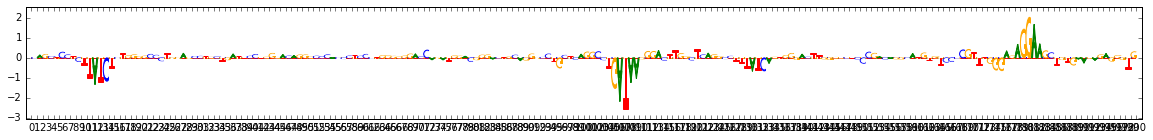

Method deeplift


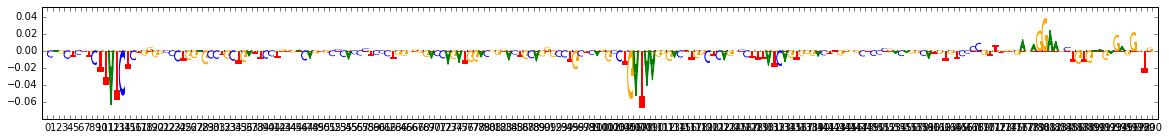

task 5
Method grad_times_inp


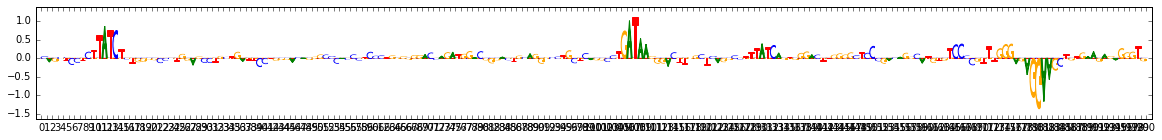

Method deeplift


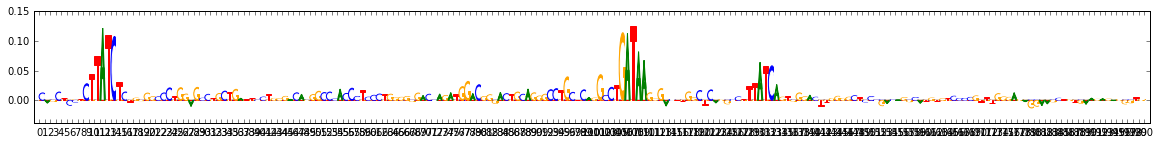

task 7
Method grad_times_inp


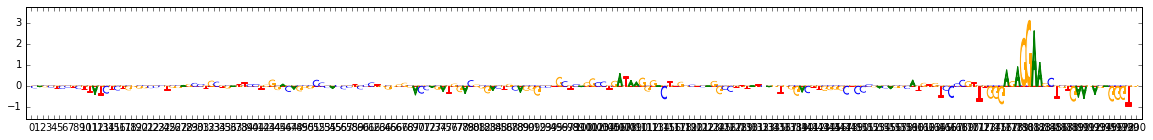

Method deeplift


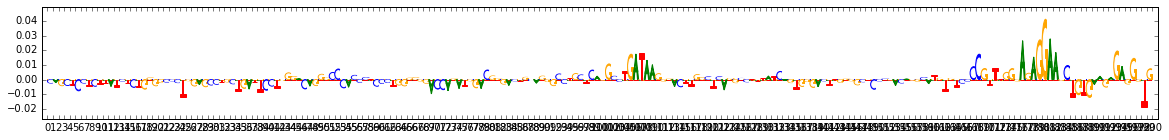

In [27]:
from avutils.util import seq_to_2d_image
from deeplift.visualization.viz_sequence import plot_weights
import numpy as np

regions_to_viz = [
    ("chr5",154033175,154034175)
]
!touch temp.bed
fh = open('temp.bed','w')
for chrom,start,end in regions_to_viz:
    fh.write(chrom+"\t"+str(start)+"\t"+str(end)+"\n")
fh.close()

#getfasta
!bedtools getfasta -fi /mnt/data/annotations/by_organism/human/hg19.GRCh37/hg19.genome.fa -tab -bed temp.bed -fo temp.fa
onehot_inp = np.array([seq_to_2d_image(x.split("\t")[1]) for x in open('temp.fa','r').read().split("\n") if len(x) > 0])

tasks = [0, 5, 7]
#compute the scores on regions_to_viz
task_to_method_to_scores = OrderedDict()

for task in tasks:
    task_to_method_to_scores[task] = OrderedDict()
    for method in method_to_func:
        task_to_method_to_scores[task][method] =\
            np.sum(method_to_func[method](
                task_idx=task,
                input_data_list = [onehot_inp],
                input_references_list = np.array([0.27, 0.23, 0.23, 0.27])[None,None,:,None],
                progress_update = None,
                batch_size=200), axis=-2)[:,:,None,:]*onehot_inp #sum scores over channel and project onto base that's present

half_window_to_plot=100 #will plot central half_window_to_plot*2 bp
midpoint = int(onehot_inp.shape[-1]/2)
for i in range(len(regions_to_viz)):
    print(regions_to_viz[i])
    for task in task_to_method_to_scores:
        print("task",task)
        for method in task_to_method_to_scores[task]:
            print("Method",method)
            scores_to_plot = task_to_method_to_scores[task][method][i][:,:,midpoint-half_window_to_plot:midpoint+half_window_to_plot]
            plot_weights(scores_to_plot)